In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/chexnet_adam_droput.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

#### Keras Callbacks

In [3]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(chexnet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(chexnet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


### ChexNet Model Compile

In [5]:
CHEXNET_WEIGHTS_PATH ='/home/ChexNet/pretrained/chexnet-pretrained-weights.h5'
base_model = DenseNet121(weights=None,include_top=False,input_shape=INPUT_SHAPE)
out = Dense(14, activation='sigmoid')(base_model.output)
base_model = Model(inputs=base_model.input, outputs=out) 
base_model.load_weights(CHEXNET_WEIGHTS_PATH)

for layer in base_model.layers:
    layer.trainable=True

chexnet_extract = base_model.layers[-2].output
chexnet_extract = GlobalAveragePooling2D()(chexnet_extract)
chexnet_extract = Dropout(0.4)(chexnet_extract)
output = Dense(3, activation='softmax')(chexnet_extract)

chexnet_model = Model(base_model.input, output)
chexnet_model.summary()

2022-08-14 11:16:32.741496: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-14 11:16:32.741556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5808 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
history = chexnet_model.fit(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/20


2022-08-14 11:16:57.565358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8428 - AUC: 0.9597 - precision: 0.8836 - recall: 0.8002
Epoch 00001: val_loss improved from inf to 1.21144, saving model to ./weights/chexnet_adam_droput.hdf5
End of epoch 0. Learning rate: 0.001
286/286 [==============================] - 139s 433ms/step - loss: 0.3906 - accuracy: 0.8428 - AUC: 0.9597 - precision: 0.8836 - recall: 0.8002 - val_loss: 1.2114 - val_accuracy: 0.3194 - val_AUC: 0.5869 - val_precision: 0.3025 - val_recall: 0.2638 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9361 - AUC: 0.9915 - precision: 0.9409 - recall: 0.9309
Epoch 00002: val_loss improved from 1.21144 to 0.19752, saving model to ./weights/chexnet_adam_droput.hdf5
End of epoch 1. Learning rate: 0.001
286/286 [==============================] - 120s 420ms/step - loss: 0.1708 - accuracy: 0.9361 - AUC: 0.9915 - precision: 0.9409 - recall: 0.9309 - val

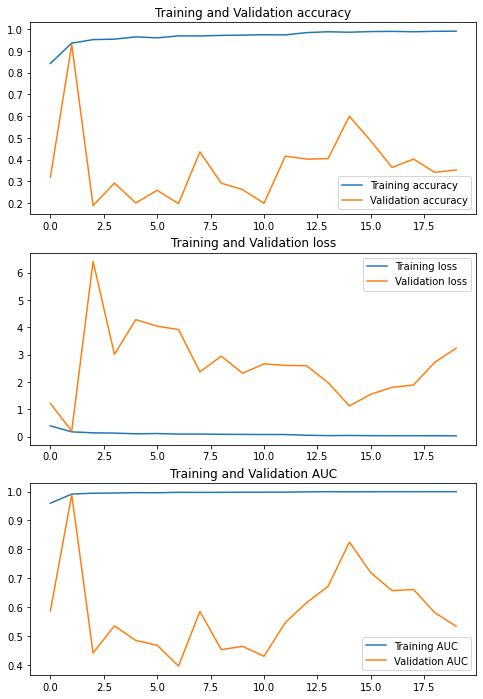

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
1,0.170778,0.936145,0.991452,0.940883,0.930887,0.197516,0.929626,0.989317,0.935452,0.927165,0.001000
14,0.038992,0.986418,0.999174,0.986950,0.985761,1.121002,0.599902,0.825230,0.615504,0.586122,0.000316
15,0.031363,0.989376,0.999407,0.989805,0.988938,1.545037,0.486220,0.719642,0.497472,0.484252,0.000316
7,0.088627,0.969222,0.997176,0.970682,0.968237,2.365411,0.435531,0.585636,0.438119,0.435531,0.001000
11,0.072589,0.974151,0.998061,0.974967,0.972618,2.604243,0.416339,0.547131,0.417284,0.415846,0.001000
13,0.033805,0.988499,0.999572,0.989470,0.988061,1.975375,0.404528,0.672155,0.405926,0.404528,0.000316
17,0.029866,0.988609,0.999459,0.988821,0.988171,1.887885,0.402559,0.661436,0.404478,0.400098,0.000316
12,0.046135,0.984666,0.999072,0.985196,0.984009,2.590883,0.402559,0.616041,0.403154,0.402559,0.000316
16,0.029020,0.990361,0.999615,0.990903,0.990252,1.801661,0.364173,0.657369,0.369238,0.362697,0.000316


#### Fine-tune ChexNet

In [10]:
# Get number of layers in the base_model
print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

chexnet_model.summary()

Number of layers in the base model:  428
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                   

In [11]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune = chexnet_model.fit(train_generator,
                            epochs=30,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/30
286/286 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9933 - AUC: 0.9996 - precision: 0.9936 - recall: 0.9930
Epoch 00020: val_loss improved from 0.19752 to 0.13137, saving model to ./weights/chexnet_adam_droput.hdf5
End of epoch 19. Learning rate: 1e-04
286/286 [==============================] - 122s 395ms/step - loss: 0.0206 - accuracy: 0.9933 - AUC: 0.9996 - precision: 0.9936 - recall: 0.9930 - val_loss: 0.1314 - val_accuracy: 0.9641 - val_AUC: 0.9929 - val_precision: 0.9641 - val_recall: 0.9636
Learning rate:  1e-04
Epoch 21/30
286/286 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9938 - AUC: 0.9997 - precision: 0.9939 - recall: 0.9934
Epoch 00021: val_loss improved from 0.13137 to 0.09822, saving model to ./weights/chexnet_adam_droput.hdf5
End of epoch 20. Learning rate: 1e-04
286/286 [==============================] - 110s 385ms/step - loss: 0.0194 - accuracy: 0.9938 - AUC: 0.

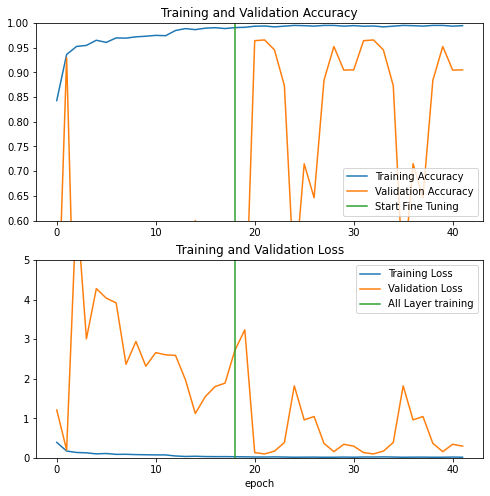

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='All Layer training')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall
epoch,,,,,,,,,,
1,0.019377,0.993757,0.999730,0.993864,0.993428,0.098221,0.965551,0.996723,0.966979,0.965551
0,0.020569,0.993319,0.999608,0.993643,0.992990,0.131370,0.964075,0.992888,0.964057,0.963583
8,0.014495,0.994962,0.999940,0.994960,0.994633,0.155154,0.952264,0.991793,0.953179,0.951772
2,0.023339,0.992004,0.999699,0.992222,0.992004,0.167917,0.945374,0.990940,0.946199,0.943406
10,0.014536,0.994524,0.999942,0.994741,0.994414,0.295511,0.905020,0.978234,0.906621,0.903051
9,0.018415,0.993428,0.999663,0.993645,0.993209,0.341545,0.904528,0.975800,0.906265,0.904035
7,0.013873,0.994962,0.999868,0.995180,0.994962,0.365042,0.883858,0.970564,0.885432,0.882382
3,0.019075,0.993428,0.999810,0.993536,0.993319,0.386904,0.873031,0.965656,0.875433,0.871555
5,0.015907,0.994414,0.999845,0.994413,0.994195,0.958161,0.715059,0.872373,0.715134,0.711614


In [19]:
history_finetune2 = chexnet_model.fit(train_generator,
                            epochs=40,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 30/40
286/286 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9943 - AUC: 0.9998 - precision: 0.9944 - recall: 0.9942
Epoch 00030: val_loss did not improve from 0.09822
End of epoch 29. Learning rate: 1e-04
286/286 [==============================] - 110s 385ms/step - loss: 0.0158 - accuracy: 0.9943 - AUC: 0.9998 - precision: 0.9944 - recall: 0.9942 - val_loss: 0.9623 - val_accuracy: 0.7052 - val_AUC: 0.8719 - val_precision: 0.7089 - val_recall: 0.6988
Learning rate:  1e-04
Epoch 31/40
286/286 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9958 - AUC: 1.0000 - precision: 0.9963 - recall: 0.9956
Epoch 00031: val_loss did not improve from 0.09822
End of epoch 30. Learning rate: 1e-04
286/286 [==============================] - 110s 382ms/step - loss: 0.0117 - accuracy: 0.9958 - AUC: 1.0000 - precision: 0.9963 - recall: 0.9956 - val_loss: 0.2227 - val_accuracy: 0.9252 - val_AUC: 0.9866 - val_prec

In [20]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall
epoch,,,,,,,,,,
6,0.011796,0.996824,0.999880,0.996933,0.996824,0.214690,0.932087,0.986447,0.932479,0.931102
1,0.011670,0.995838,0.999964,0.996274,0.995619,0.222721,0.925197,0.986593,0.927372,0.923720
7,0.012911,0.995509,0.999787,0.995618,0.995400,0.235420,0.921752,0.985588,0.923115,0.921752
8,0.010933,0.996166,0.999913,0.996166,0.996166,0.252957,0.921752,0.983652,0.922091,0.920276
3,0.013781,0.995838,0.999888,0.995947,0.995838,0.270846,0.905020,0.981262,0.905772,0.903543
5,0.014045,0.994852,0.999784,0.994961,0.994852,0.382613,0.885827,0.969851,0.888285,0.884350
4,0.012456,0.995181,0.999874,0.995399,0.995181,0.455287,0.846949,0.955756,0.848860,0.843012
2,0.014586,0.995290,0.999778,0.995835,0.995181,0.511385,0.843996,0.949641,0.847944,0.842520
10,0.010515,0.996386,0.999915,0.996386,0.996386,0.561149,0.828740,0.941907,0.832175,0.824803


### Model Evaluation

In [17]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = chexnet_model.predict(test_generator)

Found 69 images belonging to 3 classes.


In [18]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.53      0.68        40
           2       0.60      0.97      0.74        29

    accuracy                           0.71        69
   macro avg       0.78      0.75      0.71        69
weighted avg       0.80      0.71      0.70        69

